In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm

# Set plot style
sns.set_style('darkgrid')

# American Options

American options are options where the owner can choose to exercise them at _any_ point up to and including the expiration date. Because this provides an additional mechanism to exercise compared to European options (which only allow exercise at the expiration date), American options are at least as valuable as their European counterparts, and their difference depends on the value of early exercise, called the _early exercise premium_. 

The premium depends on various factors. In the Black-Scholes model, American and European call options for non-dividend-paying stocks are generally priced the same (for dividend-paying stocks, deep-in-the-money option holders may wish to exercise before a dividend date to obtain dividends). However, put options can have substantial differences when it makes sense for the option holder to exercise early and invest the income at prevailing interest rates.

## Perpetual American Put Options

The simplest theoretical case of an American Put Option is a perpetual one where the expiration date is set to infinity. One can assume that, because time is set to infinite, the strategy of whether to exercise or not depends only on the price of the stock, not on time. The price of the perpetual American put is defined as:

$$
v(x) = \max_{\tau\in T} \tilde{E}[e^{-r\tau}(K-S(\tau))]
$$

where $K$ is the strike price, $S(\tau)$ is the price of the underlying asset at time $\tau$, $T$ is the set of all stopping times, and the exponential term tracks the growth of money under fixed interest rate $r$. 

Assume that the stock asset is priced as a geometric Brownian motion:

$$
S(t) = S(0) \exp\left\{\sigma \tilde{W}(t) + \left(r-\frac{1}{2}\sigma^2\right) t\right\}
$$

with a Wiener process $\tilde{W}(t)$. If the owner uses a strategy to exercise the option as soon as it falls below a value $L$, exercising at $\tau_L = \min(t\geq 0;S(t)=L)$, then the value function is:

$$
v_L(x)=\begin{cases}
K - x, & 0 \le x \le L,\\[6pt]
(K-L)\left(\dfrac{x}{L}\right)^{-\frac{2r}{\sigma^{2}}}, & x \ge L .
\end{cases}
$$

where the first case corresponds to exercising at $t=0$ (the stock value is below $L$), and the second case is the expected value when waiting for the stock price to drop below $L$. Following Steve Shreve 8.3, this function $v_L(x)$ has a well-defined optimum at:

$$L_* = \frac{2r}{2r+\sigma^2}K$$

In [2]:
def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """
    Simulates stock paths as geometric Brownian motions.
    
    Parameters:
    -----------
    S0 : float
        Underlying stock price at time 0
    sigma : float
        Yearly volatility
    t : float
        Time to expiration (years)
    r : float
        Risk-free interest rate
    mu : float
        Drift of log-returns
    n_sims : int
        Number of simulated paths
    n_steps : int
        Number of steps in each simulated path
    
    Returns:
    --------
    np.array
        Array of stock paths with shape (n_sims, n_steps+1)
    """
    dt = t / n_steps
    noise = np.random.normal(loc=0, scale=1, size=(n_sims, n_steps))
    log_returns = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    exponent = np.cumsum(log_returns, axis=1)
    paths = S0 * np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis=1)
    
    return paths_with_start

# Monte Carlo Analysis of Perpetual American Put Options

Let's perform a Monte Carlo simulation to analyze the perpetual American put option and find the optimal exercise boundary.

In [3]:
# Model parameters
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
t = 10         # Time horizon (years)
mu = 0         # Drift (risk-neutral)

# Simulation parameters
simulation_amounts = [200]
n_steps = 1000

In [4]:
def put_option_payoff(S, K, r, t):
    """
    Calculate the discounted payoff of a put option.
    
    Parameters:
    -----------
    S : float
        Stock price at exercise
    K : float
        Strike price
    r : float
        Risk-free rate
    t : float
        Time to discount back
    
    Returns:
    --------
    float
        Discounted payoff
    """
    return max(K - S, 0) * np.exp(-r * t)

Path 1: Exercised at step 3, Stock price: 127.85, Payoff: 8.57
Path 2: Exercised at step 8, Stock price: 128.84, Payoff: 7.88
Path 3: Exercised at step 34, Stock price: 126.71, Payoff: 9.48
Path 4: Exercised at step 525, Stock price: 128.65, Payoff: 9.61
Path 5: Exercised at step 22, Stock price: 123.30, Payoff: 11.86
Path 6: Exercised at step 14, Stock price: 126.87, Payoff: 9.30
Path 7: Exercised at step 12, Stock price: 126.17, Payoff: 9.79
Path 8: Exercised at step 8, Stock price: 129.49, Payoff: 7.42
Path 9: Exercised at step 236, Stock price: 129.52, Payoff: 8.02
Path 10: Exercised at step 52, Stock price: 125.44, Payoff: 10.45
Path 11: Exercised at step 82, Stock price: 127.29, Payoff: 9.22
Path 12: Exercised at step 17, Stock price: 127.61, Payoff: 8.78
Path 13: Exercised at step 3, Stock price: 129.01, Payoff: 7.75
Path 14: Exercised at step 220, Stock price: 128.06, Payoff: 9.09
Path 15: Exercised at step 6, Stock price: 126.44, Payoff: 9.57
Path 16: Exercised at step 3, Stoc

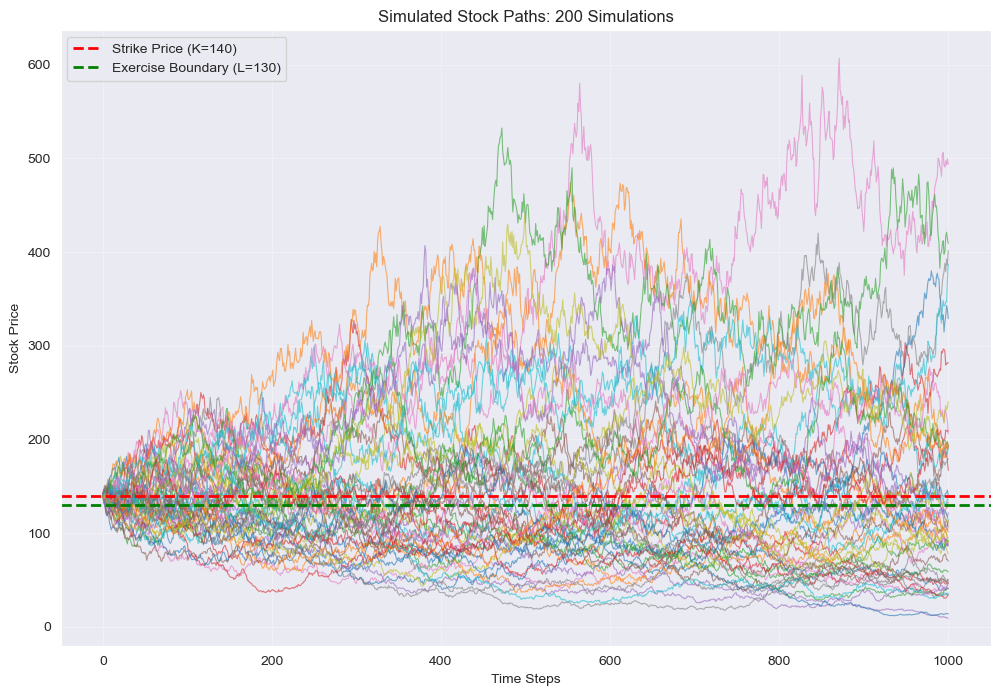


Results for 200 simulations:
Average Payoff: $8.1539
Standard Error: $0.1771
Exercise Rate: 93.50%
Average Exercise Time: 145.8 steps


In [5]:
# Simulation of perpetual American put option with fixed exercise boundary
L = 130  # Exercise boundary

for sim in simulation_amounts:
    paths = GBM_paths(S0, sigma, t, r, mu, sim, n_steps)
    
    # Calculate payoff for each path
    payoffs = []
    exercise_times = []
    
    for i in range(sim):
        path = paths[i]
        exercised = False
        
        for j in range(len(path)):
            if path[j] <= L:
                # Exercise option at first time stock hits boundary
                remaining_time = t * (1 - j / n_steps)
                payoff = put_option_payoff(path[j], K, r, remaining_time)
                payoffs.append(payoff)
                exercise_times.append(j)
                exercised = True
                print(f"Path {i+1}: Exercised at step {j}, Stock price: {path[j]:.2f}, Payoff: {payoff:.2f}")
                break
        
        if not exercised:
            # Option expires worthless
            payoffs.append(0)
            exercise_times.append(n_steps)

    # Plot simulated paths
    plt.figure(figsize=(12, 8))
    for i in range(min(sim, 50)):  # Limit to 50 paths for clarity
        plt.plot(paths[i], alpha=0.6, linewidth=0.8)
    
    plt.axhline(y=K, color='r', linestyle='--', linewidth=2, label=f'Strike Price (K={K})')
    plt.axhline(y=L, color='g', linestyle='--', linewidth=2, label=f'Exercise Boundary (L={L})')
    plt.title(f'Simulated Stock Paths: {sim} Simulations')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate statistics
    avg_payoff = np.mean(payoffs)
    std_error = np.std(payoffs) / np.sqrt(sim)
    exercise_rate = np.mean([p > 0 for p in payoffs])
    
    print(f"\nResults for {sim} simulations:")
    print(f"Average Payoff: ${avg_payoff:.4f}")
    print(f"Standard Error: ${std_error:.4f}")
    print(f"Exercise Rate: {exercise_rate:.2%}")
    print(f"Average Exercise Time: {np.mean(exercise_times):.1f} steps")

In [6]:
# Calculate theoretical optimal exercise boundary
alpha = (2 * r) / (2 * r + sigma**2)
theoretical_optimal_L = K * alpha

print(f"Alpha parameter: {alpha:.4f}")
print(f"Theoretical optimal exercise boundary: L* = {theoretical_optimal_L:.2f}")

Alpha parameter: 0.4375
Theoretical optimal exercise boundary: L* = 61.25


Testing 15 different exercise boundaries with 50000 simulations each...
L = 42.88: Average payoff = $20.0198 ± $0.1623
L = 45.50: Average payoff = $21.3921 ± $0.1626
L = 48.12: Average payoff = $22.7641 ± $0.1623
L = 50.75: Average payoff = $23.6583 ± $0.1602
L = 53.38: Average payoff = $25.0275 ± $0.1585
L = 56.00: Average payoff = $26.1864 ± $0.1561
L = 58.63: Average payoff = $26.8823 ± $0.1525
L = 61.25: Average payoff = $27.3939 ± $0.1483
L = 63.88: Average payoff = $27.7022 ± $0.1436
L = 66.50: Average payoff = $28.3603 ± $0.1391
L = 69.12: Average payoff = $28.7456 ± $0.1338
L = 71.75: Average payoff = $28.7257 ± $0.1284
L = 74.38: Average payoff = $29.0276 ± $0.1229
L = 77.00: Average payoff = $28.9412 ± $0.1171
L = 79.63: Average payoff = $28.4608 ± $0.1114

Results:
Optimal L (simulated): 74.38
Maximum average payoff: $29.0276
Theoretical optimal L: 61.25
Difference: 13.13


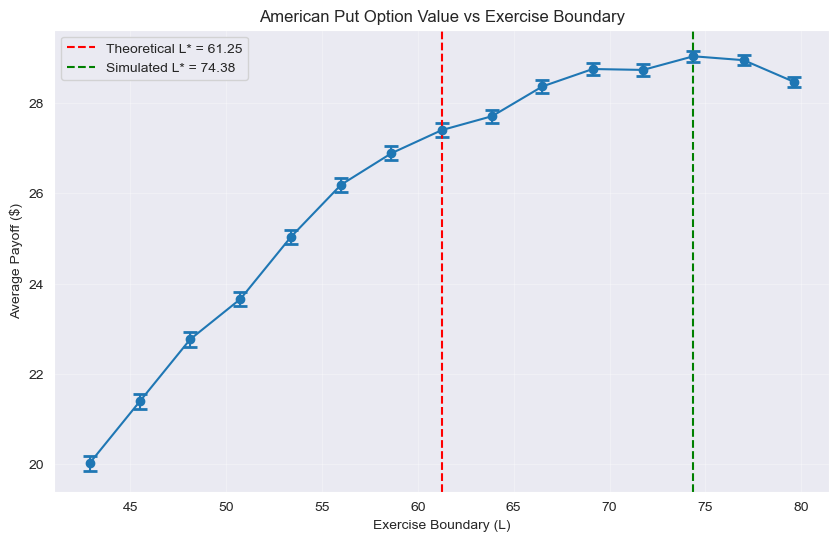

In [10]:
# Find optimal exercise boundary through Monte Carlo simulation
alpha = (2 * r) / (2 * r + sigma**2)
theoretical_L = K * alpha

# Test range of L values around theoretical optimum
L_values = np.linspace(theoretical_L * 0.7, theoretical_L * 1.3, 15)
payoff_means = []
payoff_stds = []

sim = 50000
print(f"Testing {len(L_values)} different exercise boundaries with {sim} simulations each...")

for idx, L in enumerate(L_values):
    paths = GBM_paths(S0, sigma, t, r, mu, sim, n_steps)
    
    payoffs = []
    for i in range(sim):
        path = paths[i]
        exercised = False
        
        for j in range(len(path)):
            if path[j] <= L:
                remaining_time = t * (1 - j / n_steps)
                payoff = put_option_payoff(path[j], K, r, remaining_time)
                payoffs.append(payoff)
                exercised = True
                break
        
        if not exercised:
            payoffs.append(0)
    
    avg_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)
    payoff_means.append(avg_payoff)
    payoff_stds.append(std_payoff)
    
    print(f"L = {L:.2f}: Average payoff = ${avg_payoff:.4f} ± ${std_payoff/np.sqrt(sim):.4f}")

# Find optimal L
optimal_idx = np.argmax(payoff_means)
optimal_L = L_values[optimal_idx]
max_payoff = payoff_means[optimal_idx]

print(f"\nResults:")
print(f"Optimal L (simulated): {optimal_L:.2f}")
print(f"Maximum average payoff: ${max_payoff:.4f}")
print(f"Theoretical optimal L: {theoretical_L:.2f}")
print(f"Difference: {abs(optimal_L - theoretical_L):.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(L_values, payoff_means, yerr=np.array(payoff_stds)/np.sqrt(sim), 
             marker='o', capsize=5, capthick=2)
plt.axvline(x=theoretical_L, color='r', linestyle='--', 
            label=f'Theoretical L* = {theoretical_L:.2f}')
plt.axvline(x=optimal_L, color='g', linestyle='--', 
            label=f'Simulated L* = {optimal_L:.2f}')
plt.xlabel('Exercise Boundary (L)')
plt.ylabel('Average Payoff ($)')
plt.title('American Put Option Value vs Exercise Boundary')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()